In [1]:
#!pip install utils
#!pip install folium
#!pip install pyproj

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline
import folium
from pyproj import Proj, transform
from filter_utils import grab_files, read_one, split_image, process_and_save_coordinates, get_info_coords, get_wgs84_poolcenters

# POC

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#file_path = '/content/drive/My Drive/data'
file_path = './data/'

In [5]:
files_grabbed, files_info = grab_files(file_path)

- nombre d'images: 191 , nb files info coord: 191


In [6]:
fname = files_grabbed[0]
full_img = read_one(fname)

In [7]:
NB_SPLIT = 16

img_split = split_image(full_img, NB_SPLIT)
img = img_split[101]

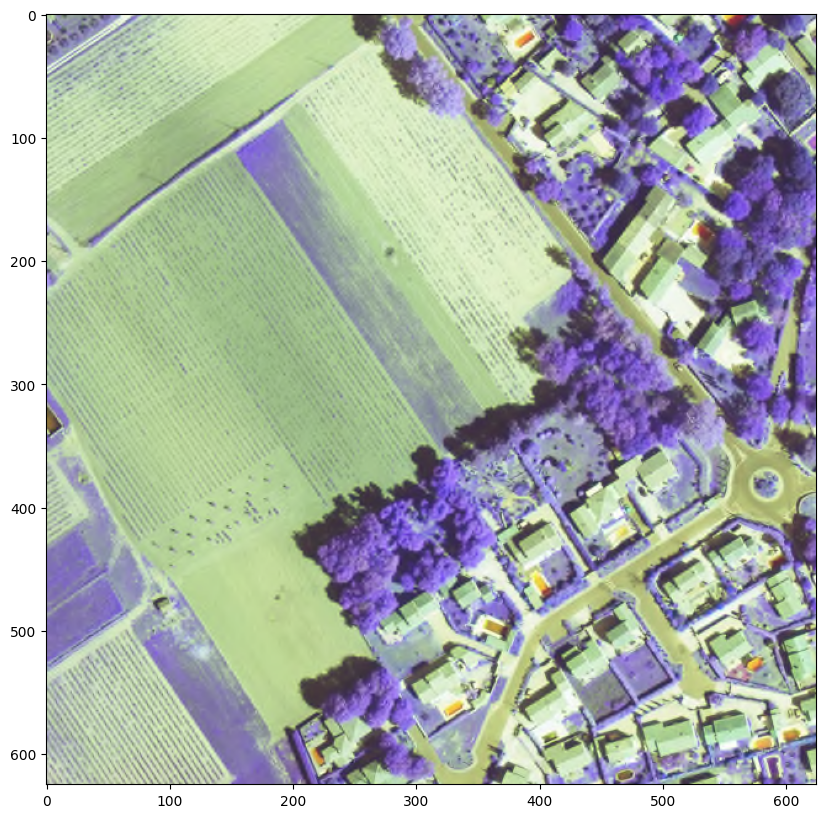

In [8]:
# Convert to HSV color space and show image
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img_bgr)
plt.show()

Filter

Number of pools detected over total contours found:  766 / 4877


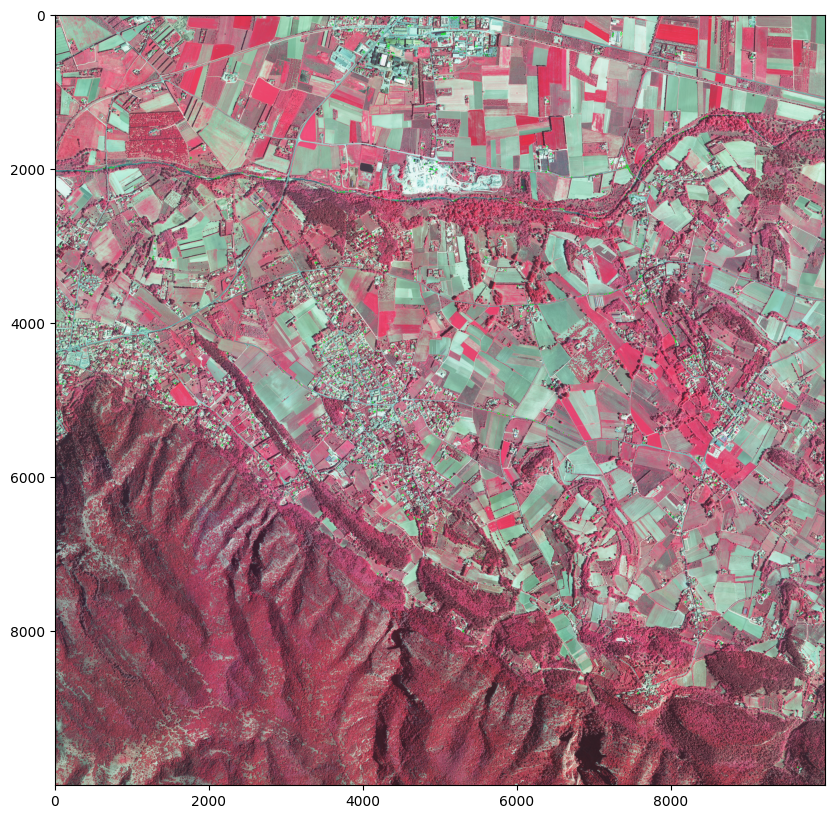

True

In [9]:
def detect_pools(image):
    # Convert to HSV color space for easier color filtering
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Yellow color range
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Orange color range
    lower_orange = np.array([10, 90, 90])
    upper_orange = np.array([20, 255, 255])

    # Red color range (might need two parts)
    # Lower red
    lower_red1 = np.array([0, 75, 75])
    upper_red1 = np.array([10, 255, 255])

    # Create masks for each color
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    #mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combine masks
    mask = cv2.bitwise_or(mask_yellow, mask_orange)
    mask = cv2.bitwise_or(mask, mask_red1)
    #mask = cv2.bitwise_or(mask, mask_red2)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    nb_contours = len(contours)
    nb_contours_retained = 0

    # Filter for rectangular or circular shapes
    for cnt in contours:
        # Erase too small contours
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        if radius < 3.2 or radius > 13:
            continue
        nb_contours_retained += 1

        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(image, center, radius, (0, 255, 0), 3)

    # Display the number of pools detected
    print("Number of pools detected over total contours found: ", nb_contours_retained, "/", nb_contours)

    return image

img_copy = np.copy(full_img)
result = detect_pools(img_copy)
if result is not None:
    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.show()

# Save the image
cv2.imwrite('analysis/result.jpg', result)

## Implementation of the filter

In [10]:
# Implem on whole image
original_width, original_height, _ = full_img.shape
pool_centers = process_and_save_coordinates(full_img, NB_SPLIT, original_width, original_height)
print(pool_centers)

[(471, 458), (222, 316), (1248, 191), (1207, 153), (1309, 459), (1414, 350), (1306, 209), (1254, 191), (1571, 2), (2668, 27), (3601, 124), (3666, 31), (4213, 594), (4369, 568), (4224, 556), (4373, 493), (4331, 490), (4322, 485), (4006, 484), (4328, 435), (4305, 420), (4331, 411), (4324, 408), (4313, 401), (4329, 393), (4194, 371), (4251, 225), (3812, 197), (3847, 194), (4082, 55), (3854, 46), (3973, 34), (3924, 38), (3773, 20), (4029, 3), (4397, 535), (4395, 499), (4377, 493), (4974, 322), (4457, 311), (4586, 149), (4607, 136), (4428, 6), (5604, 521), (5597, 509), (5567, 504), (5233, 473), (5316, 469), (5258, 445), (5606, 427), (5471, 406), (5453, 406), (5204, 396), (5116, 318), (5005, 250), (5014, 248), (5026, 247), (5044, 244), (5060, 242), (5332, 231), (5243, 112), (5316, 111), (5346, 104), (5302, 88), (5227, 75), (5174, 52), (5198, 46), (5157, 36), (5140, 36), (5200, 37), (5216, 29), (5202, 29), (5180, 30), (5108, 29), (5503, 1), (5190, 3), (7052, 497), (7233, 278), (7234, 271), (7

In [11]:
print(len(pool_centers))

782


### Transforming the data to lambert then to wgs84

In [12]:
coords = get_info_coords(files_info[0])

print(coords)

[[ 830000. 6355000.]
 [ 835000. 6355000.]
 [ 835000. 6350000.]
 [ 830000. 6350000.]]


In [13]:
lambert_proj = Proj(init='epsg:2154')   # Lambert-93 projection
wgs84_proj = Proj(init='epsg:4326')

/home/coartix/.local/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/coartix/.local/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [14]:
img_width, img_height = 10000, 10000

wgs84_pool_centers = get_wgs84_poolcenters(img_width, img_height, pool_centers, coords, lambert_proj, wgs84_proj)
print(wgs84_pool_centers)

/home/coartix/S9-EPITA/ALEIA/General/PoolFinder/filter_utils.py:143: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(lambert_proj, wgs84_proj, x_lambert, y_lambert)


[(4.63188568265276, 44.27984695922354), (4.630344473894387, 44.2805090591384), (4.636786969198804, 44.28097599460132), (4.636535100661444, 44.28115080608208), (4.637134232931629, 44.2797643952437), (4.637806045082357, 44.28024505877318), (4.637147912382856, 44.280889589589584), (4.636824549998643, 44.280975434882976), (4.638834640569627, 44.28179628019263), (4.645702482755732, 44.28158111212529), (4.651533627566428, 44.28105698219379), (4.651952939980548, 44.28146932999693), (4.655305135040252, 44.27888448188364), (4.656285611027179, 44.27898675085534), (4.65537902052589, 44.27905443017269), (4.656320518643647, 44.2793238456925), (4.6560578561726444, 44.27934130900787), (4.656002143744454, 44.279364656609694), (4.6540230847057025, 44.27939896257439), (4.656046292080549, 44.279589071990706), (4.655904207072859, 44.279658737207455), (4.656068235001175, 44.27969678005002), (4.6560247860705655, 44.27971093963096), (4.65595680940926, 44.27974347524437), (4.656058073210693, 44.27977796222813

# Mapping the pools on the map

In [15]:
# From this wgs84_pool_centers list, we can create a GeoJSON file to visualize the pools on a map.
import json

geojson = {
    "type": "FeatureCollection",
    "features": []
}

for lon, lat in wgs84_pool_centers:
    geojson["features"].append({
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [lon, lat]
        }
    })

with open('analysis/pools.geojson', 'w') as f:
    json.dump(geojson, f)


In [17]:
# We can then visualize the GeoJSON file on a map using the Python folium library.
# Create map
m = folium.Map(location=[45.5, 4.5], zoom_start=12)
# Add GeoJSON file
folium.GeoJson('analysis/pools.geojson').add_to(m)

m